# Machine Learning with PyTorch and Scikit-Learn  
# -- Code Examples

## Package version checks

Add folder to path in order to load from the check_packages.py script:

In [1]:
import sys
sys.path.insert(0, '..')

Check recommended package versions:

In [2]:
from python_environment_check import check_packages


d = {
    'torch': '1.8',
    'torchvision': '0.9.0',
    'tensorboard': '2.7.0',
    'pytorch_lightning': '1.5.0',
    'torchmetrics': '0.6.2'
}
check_packages(d)

[OK] Your Python version is 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0]
[OK] torch 1.10.0
[OK] torchvision 0.11.1
[OK] tensorboard 2.8.0
[OK] pytorch_lightning 1.5.0
[OK] torchmetrics 0.7.0


# Chapter 13: Going Deeper -- the Mechanics of PyTorch (Part 3/3)

**Outline**

- [Higher-level PyTorch APIs: a short introduction to PyTorch Lightning](#Higher-level-PyTorch-APIs-a-short-introduction-to-PyTorch-Lightning)
  - [Setting up the PyTorch Lightning model](#Setting-up-the-PyTorch-Lightning-model)
  - [Setting up the data loaders for Lightning](#Setting-up-the-data-loaders-for-Lightning)
  - [Training the model using the PyTorch Lightning Trainer class](#Training-the-model-using-the-PyTorch-Lightning-Trainer-class)
  - [Evaluating the model using TensorBoard](#Evaluating-the-model-using-TensorBoard)
- [Summary](#Summary)

## Higher-level PyTorch APIs: a short introduction to PyTorch Lightning

### Setting up the PyTorch Lightning model

## Higher-level PyTorch APIs: a short introduction to PyTorch Lightning

### Setting up the PyTorch Lightning model

In [3]:
import pytorch_lightning as pl
import torch 
import torch.nn as nn 

from torchmetrics import Accuracy

In [4]:
class MultiLayerPerceptron(pl.LightningModule):
    def __init__(self, image_shape=(1, 28, 28), hidden_units=(32, 16)):
        super().__init__()
        
        # new PL attributes:
        self.train_acc = Accuracy()
        self.valid_acc = Accuracy()
        self.test_acc = Accuracy()
        
        # Model similar to previous section:
        input_size = image_shape[0] * image_shape[1] * image_shape[2] 
        all_layers = [nn.Flatten()]
        for hidden_unit in hidden_units: 
            layer = nn.Linear(input_size, hidden_unit) 
            all_layers.append(layer) 
            all_layers.append(nn.ReLU()) 
            input_size = hidden_unit 
 
        all_layers.append(nn.Linear(hidden_units[-1], 10)) 
        self.model = nn.Sequential(*all_layers)

    def forward(self, x):
        x = self.model(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.train_acc.update(preds, y)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def training_epoch_end(self, outs):
        self.log("train_acc", self.train_acc.compute())
        self.train_acc.reset()
    
    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.valid_acc.update(preds, y)
        self.log("valid_loss", loss, prog_bar=True)
        return loss
    
    def validation_epoch_end(self, outs):
        self.log("valid_acc", self.valid_acc.compute(), prog_bar=True)
        self.valid_acc.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = nn.functional.cross_entropy(logits, y)
        preds = torch.argmax(logits, dim=1)
        self.test_acc.update(preds, y)
        self.log("test_loss", loss, prog_bar=True)
        self.log("test_acc", self.test_acc.compute(), prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=0.001)
        return optimizer

### Setting up the data loaders

In [5]:
from torch.utils.data import DataLoader
from torch.utils.data import random_split
 
from torchvision.datasets import MNIST
from torchvision import transforms

In [6]:
class MnistDataModule(pl.LightningDataModule):
    def __init__(self, data_path='./'):
        super().__init__()
        self.data_path = data_path
        self.transform = transforms.Compose([transforms.ToTensor()])
        
    def prepare_data(self):
        MNIST(root=self.data_path, download=True) 

    def setup(self, stage=None):
        # stage is either 'fit', 'validate', 'test', or 'predict'
        # here note relevant
        mnist_all = MNIST( 
            root=self.data_path,
            train=True,
            transform=self.transform,  
            download=False
        ) 

        self.train, self.val = random_split(
            mnist_all, [55000, 5000], generator=torch.Generator().manual_seed(1)
        )

        self.test = MNIST( 
            root=self.data_path,
            train=False,
            transform=self.transform,  
            download=False
        ) 

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=64, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=64, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=64, num_workers=4)
    
    
torch.manual_seed(1) 
mnist_dm = MnistDataModule()

### Training the model using the PyTorch Lightning Trainer class

In [7]:
from pytorch_lightning.callbacks import ModelCheckpoint


mnistclassifier = MultiLayerPerceptron()

callbacks = [ModelCheckpoint(save_top_k=1, mode='max', monitor="valid_acc")] # save top 1 model

if torch.cuda.is_available(): # if you have GPUs
    trainer = pl.Trainer(max_epochs=10, callbacks=callbacks, gpus=1)
else:
    trainer = pl.Trainer(max_epochs=10, callbacks=callbacks)

trainer.fit(model=mnistclassifier, datamodule=mnist_dm)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name      | Type       | Params
-----------------------------------------
0 | train_acc | Accuracy   | 0     
1 | valid_acc | Accuracy   | 0     
2 | test_acc  | Accuracy   | 0     
3 | model     | Sequential | 25.8 K
-----------------------------------------
25.8 K    Trainable params
0         Non-trainable params
25.8 K    Total params
0.103     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

### Evaluating the model using TensorBoard

In [8]:
trainer.test(model=mnistclassifier, datamodule=mnist_dm, ckpt_path='best')

Restoring states from the checkpoint path at /home/raschka/scratch/lightning-new/lightning_logs/version_0/checkpoints/epoch=8-step=7739.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from checkpoint at /home/raschka/scratch/lightning-new/lightning_logs/version_0/checkpoints/epoch=8-step=7739.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9499600529670715, 'test_loss': 0.14912301301956177}
--------------------------------------------------------------------------------


[{'test_loss': 0.14912301301956177, 'test_acc': 0.9499600529670715}]

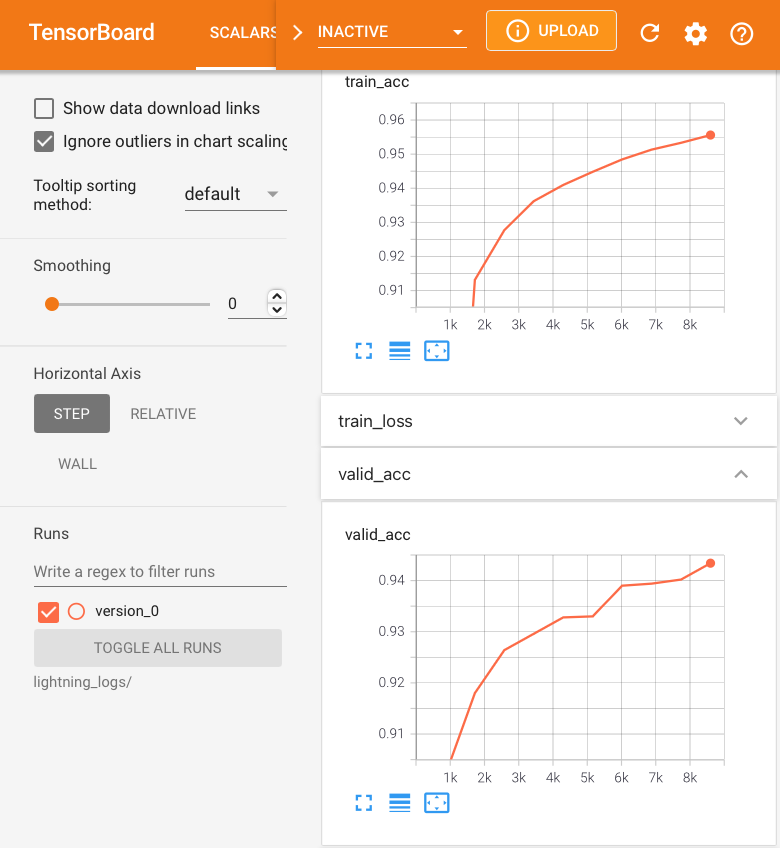

In [9]:
from IPython.display import Image
Image(filename='figures/01.png') 

In [10]:
# Start tensorboard
%load_ext tensorboard
%tensorboard --logdir lightning_logs/

In [11]:
path = 'lightning_logs/version_0/checkpoints/epoch=8-step=7739.ckpt'

if torch.cuda.is_available(): # if you have GPUs
    trainer = pl.Trainer(
        max_epochs=30, callbacks=callbacks, resume_from_checkpoint=path, gpus=1
    )
else:
    trainer = pl.Trainer(
        max_epochs=30, callbacks=callbacks, resume_from_checkpoint=path
    )

trainer.fit(model=mnistclassifier, datamodule=mnist_dm)

/home/raschka/miniforge3/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/checkpoint_connector.py:45: LightningDeprecationWarning: Setting `Trainer(resume_from_checkpoint=)` is deprecated in v1.5 and will be removed in v1.7. Please pass `Trainer.fit(ckpt_path=)` directly instead.
  rank_zero_deprecation(
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/raschka/miniforge3/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1893: LightningDeprecationWarning: `trainer.resume_from_checkpoint` is deprecated in v1.5 and will be removed in v1.7. Specify the fit checkpoint path with `trainer.fit(ckpt_path=)` instead.
  rank_zero_deprecation(
/home/raschka/miniforge3/lib/python3.8/site-packages/pytorch_lightning/core/datamodule

Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/home/raschka/miniforge3/lib/python3.8/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


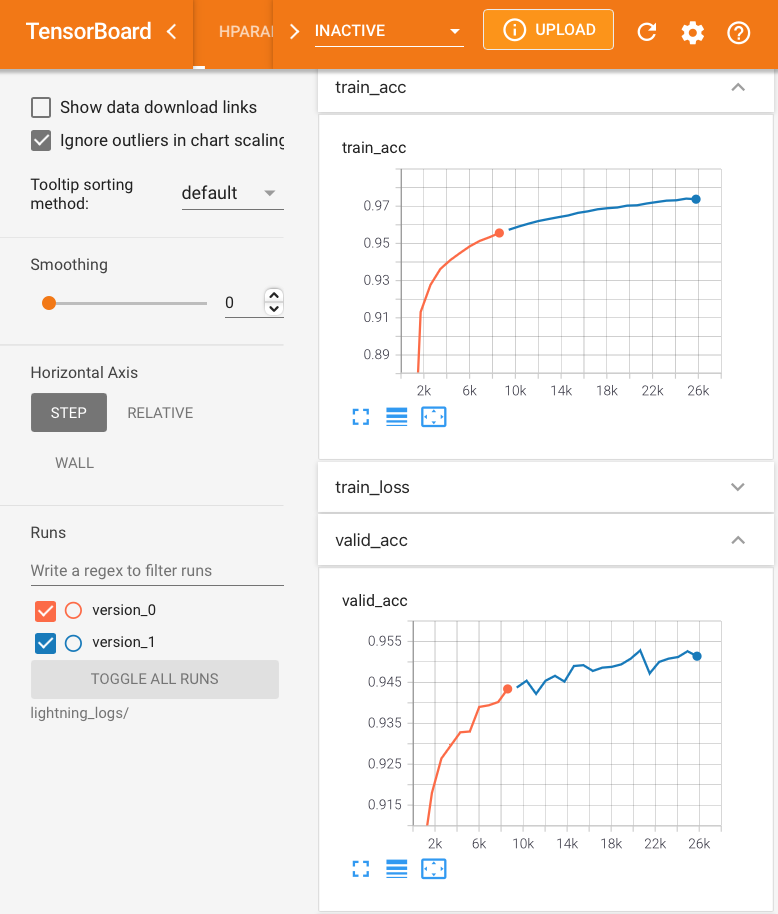

In [12]:
from IPython.display import Image
Image(filename='figures/02.png') 

In [13]:
%tensorboard --logdir lightning_logs/

Reusing TensorBoard on port 6006 (pid 702), started 0:02:27 ago. (Use '!kill 702' to kill it.)

In [14]:
trainer.test(model=mnistclassifier, datamodule=mnist_dm)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9538978338241577, 'test_loss': 0.1914435774087906}
--------------------------------------------------------------------------------


[{'test_loss': 0.1914435774087906, 'test_acc': 0.9538978338241577}]

In [15]:
trainer.test(model=mnistclassifier, datamodule=mnist_dm, ckpt_path='best')

Restoring states from the checkpoint path at /home/raschka/scratch/lightning-new/lightning_logs/version_0/checkpoints/epoch=17-step=15479.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]
Loaded model weights from checkpoint at /home/raschka/scratch/lightning-new/lightning_logs/version_0/checkpoints/epoch=17-step=15479.ckpt


Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_acc': 0.9552595019340515, 'test_loss': 0.1525387316942215}
--------------------------------------------------------------------------------


[{'test_loss': 0.1525387316942215, 'test_acc': 0.9552595019340515}]

In [16]:
path = "lightning_logs/version_0/checkpoints/epoch=17-step=15479.ckpt"
model = MultiLayerPerceptron.load_from_checkpoint(path)

## Summary

---

Readers may ignore the next cell.

In [17]:
! python ../.convert_notebook_to_script.py --input ch13_part3_lightning.ipynb --output ch13_part3_lightning.py

[NbConvertApp] Converting notebook ch13_part3_lightning.ipynb to script
[NbConvertApp] Writing 7262 bytes to ch13_part3_lightning.py
